In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as kmeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr as pears
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras
#from keras.utils import to_categorical

excelpath = 'excel_gaming_data'
ddict = {} # Created A dataframe dictionary to modify each dictionary iteratively
for filename in os.listdir(excelpath): # Iterates through each excel file
    f = os.path.join(excelpath, filename)
    # checking if it is a file
    if os.path.isfile(f) & ~filename.startswith('.'):
        ddict[filename[-6:-4]] = pd.read_excel(excelpath + '/' + filename) # sets the value of each dictionary
        
        for idx, val in enumerate(ddict[filename[-6:-4]].iloc[0,:]): # Iterates through each column of the excel spread sheet in question
            if idx > 1:
                if idx > 7:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-6:-4]) # Changes the column name using the next year and the month. The next year is used if past December, which corresponds to an index of 7, ad
                else:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-9:-7]) # Changes the column name using the first year specified and the month
        if filename[-6:-4] != '11': # Removes the first 2 columns of the excel spread sheet, except if it is the starting year spread sheet
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            
gamedf = ddict['11'] # initializes the dataframe for our game data
for ind in range(12,21): # Concatenates all dictionary values into one pandas dataframe
    gamedf = pd.concat([gamedf,ddict[str(ind)]],axis=1)

# Changed some column names:
gamedf.columns.values[0] = 'Location' 
gamedf.columns.values[1] = 'Attributes'
gamedf = gamedf.drop(0) # Removes the first row 
gamedf = gamedf.iloc[0:429,:] # We had extra noisy data, which I just removed, since it did not correspond to a date.
# I don't know why this is, hopefully it didn't correspond to other data, but I didn't see any missing data.
gamedf_T=gamedf.T #transforme the data so attributes are the columns.
gamedf_T.columns = gamedf_T.iloc[1] #reindexing b/c of the transformation
gamedf_T=gamedf_T.drop(gamedf_T.index[[1]]) #Droping the uneeded index row

colval = gamedf_T.columns[0] # The first column header device

# Renamed the column headers so each attribute is unique to a device. This will allow us to reference these headers.
for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind - 1]):
        colval = gamedf_T.columns[ind]

    if (not pd.isna(gamedf_T.columns[ind - 1])) and (not pd.isna(gamedf_T.columns[ind])):
        gamedf_T.columns.values[ind] = str(colval) + ' ' + str(gamedf_T.columns[ind])

for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind]):
        gamedf_T.columns.values[ind] = 'trash'

gamedf_T.drop(['trash'], axis = 1, inplace = True)

# Filled in missing values using the mean of the corresponding column
for col in gamedf_T.columns:
    avg = gamedf_T[col].mean()
    gamedf_T[col].fillna(avg, inplace = True)


#Splitting the data into four tables, one for each location and one for state wide totals
#This helps tidy the data making removingin the location row
filt = (gamedf_T == 'Statewide').any()
state = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Cripple Creek').any()
cripple = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Black Hawk').any()
black = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Central City').any()
central = gamedf_T.loc[: , filt].drop(['Location'])

gamedf_T.drop(['Location'], inplace = True)
gamedf_T.reset_index(inplace = True)

#seperate the date column into month and year columns
gamedf_T[['month','year']] = gamedf_T.iloc[:,0].str.split(expand=True)

#grouping months into ther respective seasons
Winter = [x.upper() for x in ['December', 'January', 'February']]
Spring = [x.upper() for x in ['March', 'April', 'May']]
Summer = [x.upper() for x in ['June', 'July', 'August']]
Autumn = [x.upper() for x in ['September', 'October', 'November']]

winterfilt = (gamedf_T['month'].isin(Winter))
springfilt = (gamedf_T['month'].isin(Spring))
summerfilt = (gamedf_T['month'].isin(Summer))
autumnfilt = (gamedf_T['month'].isin(Autumn))

#creating a now column for the season
gamedf_T['season'] = np.nan

gamedf_T.loc[winterfilt,'season'] = 'WINTER'
gamedf_T.loc[springfilt,'season'] = 'SPRING'
gamedf_T.loc[summerfilt,'season'] = 'SUMMER'
gamedf_T.loc[autumnfilt,'season'] = 'AUTUMN'

#splitting the date so each location table has a month and a year column
state.reset_index(inplace=True)
state[['month','year']] = state.iloc[:,0].str.split(expand=True)

cripple.reset_index(inplace=True)
cripple[['month','year']] = cripple.iloc[:,0].str.split(expand=True)

black.reset_index(inplace=True)
black[['month','year']] = black.iloc[:,0].str.split(expand=True)

central.reset_index(inplace=True)
central[['month','year']] = central.iloc[:,0].str.split(expand=True)


#create a df containing only the yearly total values. This makes working with just the totals easier
monchoose = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER', 'JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE']
state_totals= state.loc[state['month'].isin(monchoose)]
cripple_totals= cripple.loc[cripple['month'].isin(monchoose)]
black_totals= black.loc[black['month'].isin(monchoose)]
central_totals= central.loc[central['month'].isin(monchoose)]



/tmp/ipykernel_141/3852726001.py:65: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg = gamedf_T[col].mean()


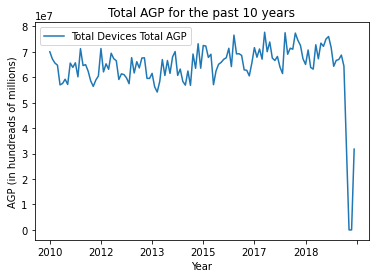

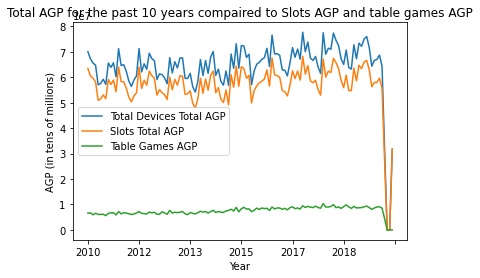

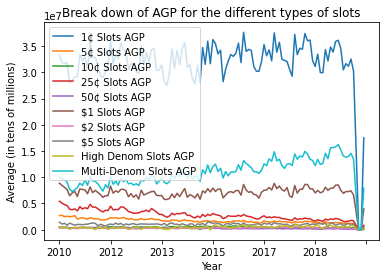

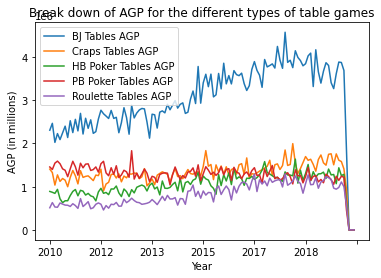

In [15]:
#Doing some initial exploring of the attributes over time
#plot 1: State wide AGP vs month
ax = plt.gca()
state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in hundreads of millions)")
plt.show()


#Plot 2: State wide total AGP, slots AGP, and table games AGP vs month
ax = plt.gca()
state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Table Games AGP',ax=ax)
plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#Plot 3: State wide AGP for different slot types vs month
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)
plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()

#plot 4: State wide AGP for different table games vs month
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)
plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()



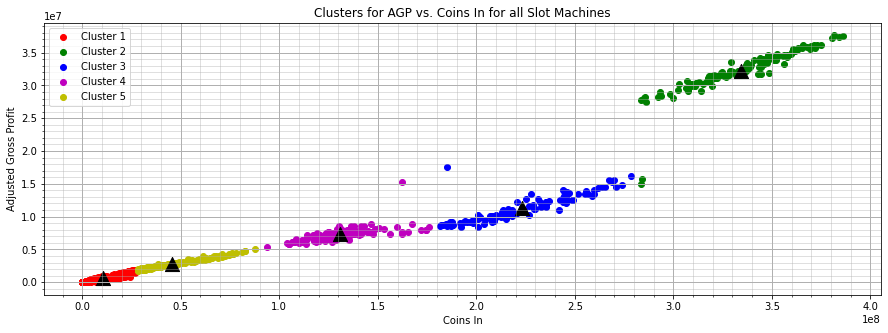

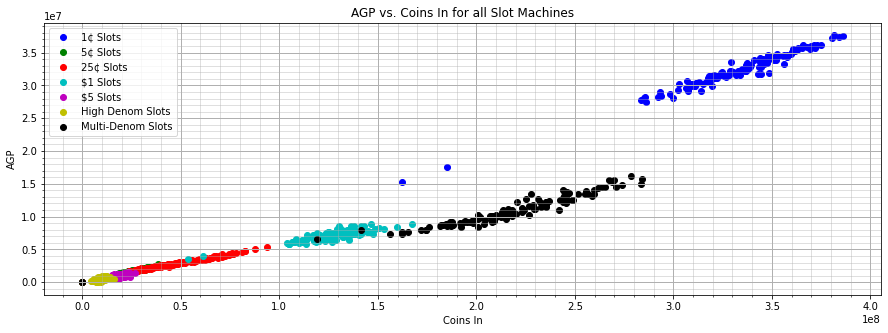

In [3]:
slotfilt = (state['month'].isin(monchoose))
#print(state)
allsltagp = pd.concat([state.loc[slotfilt,'1¢ Slots AGP'],state.loc[slotfilt,'5¢ Slots AGP'],state.loc[slotfilt,'10¢ Slots AGP'],state.loc[slotfilt,'25¢ Slots AGP'],state.loc[slotfilt,'50¢ Slots AGP'],state.loc[slotfilt,'$1 Slots AGP'],state.loc[slotfilt,'$2 Slots AGP'],state.loc[slotfilt,'$5 Slots AGP'],state.loc[slotfilt,'High Denom Slots AGP'],state.loc[slotfilt,'Multi-Denom Slots AGP']])
allsltcoin = pd.concat([state.loc[slotfilt,'1¢ Slots Coins In'],state.loc[slotfilt,'5¢ Slots Coins In'],state.loc[slotfilt,'10¢ Slots Coins In'],state.loc[slotfilt,'25¢ Slots Coins In'],state.loc[slotfilt,'50¢ Slots Coins In'],state.loc[slotfilt,'$1 Slots Coins In'],state.loc[slotfilt,'$2 Slots Coins In'],state.loc[slotfilt,'$5 Slots Coins In'],state.loc[slotfilt,'High Denom Slots Coins In'],state.loc[slotfilt,'Multi-Denom Slots Coins In']])

plt.rcParams['figure.figsize'] = [15,5]
allsltagp = allsltagp.to_numpy()
allsltcoin = allsltcoin.to_numpy()

points = np.vstack((allsltcoin,allsltagp)).T
kmeansmodel = kmeans(n_clusters=5)
values = kmeansmodel.fit_predict(points)
centind0 = np.where(values[:] == 0)[0]
centind1 = np.where(values[:] == 1)[0]
centind2 = np.where(values[:] == 2)[0]
centind3 = np.where(values[:] == 3)[0]
centind4 = np.where(values[:] == 4)[0]
centroids = kmeansmodel.cluster_centers_

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)

plt.scatter(allsltcoin[centind0],allsltagp[centind0],color='r',label='Cluster 1')
plt.scatter(allsltcoin[centind1],allsltagp[centind1],color='g',label='Cluster 2')
plt.scatter(allsltcoin[centind2],allsltagp[centind2],color='b',label='Cluster 3')
plt.scatter(allsltcoin[centind3],allsltagp[centind3],color='m',label='Cluster 4')
plt.scatter(allsltcoin[centind4],allsltagp[centind4],color='y',label='Cluster 5')
plt.scatter(centroids[:,0],centroids[:,1],color='k', marker='^', s = 200)
plt.xlabel('Coins In')
plt.ylabel('Adjusted Gross Profit')
plt.title('Clusters for AGP vs. Coins In for all Slot Machines')
plt.legend()
plt.savefig('slots-clusters.png')

plt.figure(2)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.scatter(state.loc[slotfilt,'1¢ Slots Coins In'],state.loc[slotfilt,'1¢ Slots AGP'],color='b',label='1¢ Slots')
plt.scatter(state.loc[slotfilt,'5¢ Slots Coins In'],state.loc[slotfilt,'5¢ Slots AGP'],color='g',label='5¢ Slots')
plt.scatter(state.loc[slotfilt,'25¢ Slots Coins In'],state.loc[slotfilt,'25¢ Slots AGP'],color='r',label='25¢ Slots')
plt.scatter(state.loc[slotfilt,'$1 Slots Coins In'],state.loc[slotfilt,'$1 Slots AGP'],color='c',label='$1 Slots')
plt.scatter(state.loc[slotfilt,'$5 Slots Coins In'],state.loc[slotfilt,'$5 Slots AGP'],color='m',label='$5 Slots')
plt.scatter(state.loc[slotfilt,'High Denom Slots Coins In'],state.loc[slotfilt,'High Denom Slots AGP'],color='y',label='High Denom Slots')
plt.scatter(state.loc[slotfilt,'Multi-Denom Slots Coins In'],state.loc[slotfilt,'Multi-Denom Slots AGP'],color='k',label='Multi-Denom Slots')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.title('AGP vs. Coins In for all Slot Machines')
plt.legend()

plt.savefig('slots-coins_in_vs_agp.png')

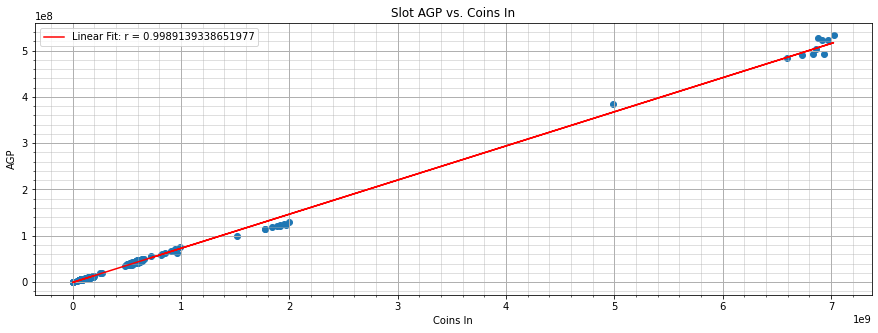

In [4]:
slotcoin = pd.concat([cripple.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total Coins In']],axis=0)
slotagp = pd.concat([cripple.loc[:,'Slots Total AGP'],black.loc[:,'Slots Total AGP'],central.loc[:,'Slots Total AGP']],axis=0)
slotagp = slotagp.to_numpy()
slotcoin = slotcoin.to_numpy()

xdata = slotcoin.reshape(-1,1)
ydata = slotagp.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(xdata, ydata)
ydata_pred = linreg.predict(xdata)
corr = pears(xdata.flatten(),ydata)[0][0]

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(xdata,ydata_pred,'r')
plt.scatter(slotcoin,slotagp)
plt.title('Slot AGP vs. Coins In')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.legend(['Linear Fit: r = ' + str(corr)], loc='upper left')
plt.rcParams['figure.figsize'] = [10,5]
plt.savefig('cluster-linear_regression.png')

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


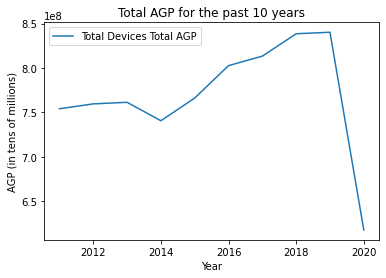

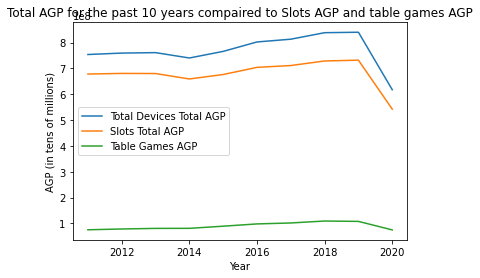

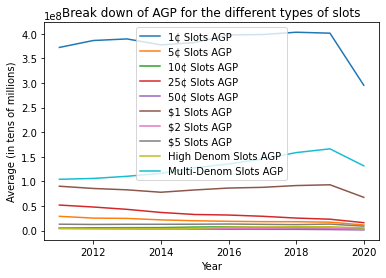

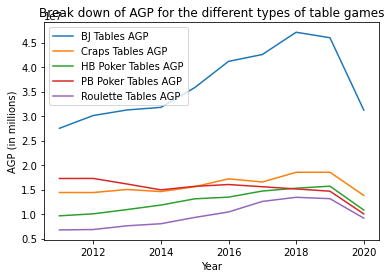

In [18]:

#looking only at anual totals rater than monthly ones
state_total= state.loc[(state['month'].isin(['TOTAL']))]
state_total.loc[:,'year'] = state_total.loc[:,'year'].astype(int)
state_total=state_total.loc[(state_total['year'] < 2021)] #not including the 2021 year becasue it is not complete

#plot 1: State wide AGP vs year
ax = plt.gca()
state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()

#Plot 2: State wide total AGP, slots AGP, and table games AGP vs year
ax = plt.gca()
state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Table Games AGP',ax=ax)
plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()

#Plot 3: State wide AGP for different slot types vs year
ax = plt.gca()

state_total.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()

#plot 4: State wide AGP for different table games vs month
ax = plt.gca()
state_total.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()



In [6]:
gamedf_T_mod = gamedf_T.dropna(axis=0)

winfilt = (gamedf_T_mod.loc[:,'season'] == 'WINTER')
gamedf_T_mod.loc[winfilt,'season'] = 0
winfilt = (gamedf_T_mod['season'] == 'SPRING')
gamedf_T_mod.loc[winfilt,'season'] = 1
winfilt = (gamedf_T_mod['season'] == 'SUMMER')
gamedf_T_mod.loc[winfilt,'season'] = 2
winfilt = (gamedf_T_mod['season'] == 'AUTUMN')
gamedf_T_mod.loc[winfilt,'season'] = 3

slotscoinsin = gamedf_T_mod.loc[:,'Slots Total Coins In'].to_numpy()[:,1:].flatten(order='F')
slotsagp = gamedf_T_mod.loc[:,'Slots Total AGP'].to_numpy()[:,1:].flatten(order='F')
slotshold = gamedf_T_mod.loc[:,'Slots Total Hold %'].to_numpy()[:,1:].flatten(order='F')
slotsseason = gamedf_T_mod.loc[:,'season'].to_numpy().flatten(order='F')
# 'Slots Total Hold %'
slotsseason = np.c_[ slotsseason, slotsseason, slotsseason ].flatten(order='F')
slotsseason = to_categorical(slotsseason, num_classes = 4)

xdata = np.c_[slotscoinsin, slotsagp, slotshold]
xdata = xdata / xdata.max(axis=0)

x_train, x_test, y_train, y_test = train_test_split(xdata, slotsseason, test_size=1/10, random_state=101, shuffle=True)
y_train = np.asarray(y_train, dtype= np.int64)
y_test = np.asarray(y_test, dtype= np.int64)
x_train = np.asarray(x_train, dtype= np.float64)
x_test = np.asarray(x_test, dtype= np.float64)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(3,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)
numepochs = 100
seasmodmetrics = model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = numepochs, shuffle = True, verbose = 2)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
2021-12-09 23:20:02.933020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other op

Epoch 1/100
33/33 - 1s - loss: 1.4055 - categorical_accuracy: 0.2407 - val_loss: 1.3724 - val_categorical_accuracy: 0.3333
Epoch 2/100
33/33 - 0s - loss: 1.4024 - categorical_accuracy: 0.2438 - val_loss: 1.3734 - val_categorical_accuracy: 0.2778
Epoch 3/100
33/33 - 0s - loss: 1.3998 - categorical_accuracy: 0.2160 - val_loss: 1.3743 - val_categorical_accuracy: 0.2500
Epoch 4/100
33/33 - 0s - loss: 1.3979 - categorical_accuracy: 0.2407 - val_loss: 1.3752 - val_categorical_accuracy: 0.2500
Epoch 5/100
33/33 - 0s - loss: 1.3960 - categorical_accuracy: 0.2469 - val_loss: 1.3762 - val_categorical_accuracy: 0.2500
Epoch 6/100
33/33 - 0s - loss: 1.3946 - categorical_accuracy: 0.2469 - val_loss: 1.3768 - val_categorical_accuracy: 0.2500
Epoch 7/100
33/33 - 0s - loss: 1.3932 - categorical_accuracy: 0.2315 - val_loss: 1.3780 - val_categorical_accuracy: 0.2500
Epoch 8/100
33/33 - 0s - loss: 1.3922 - categorical_accuracy: 0.2315 - val_loss: 1.3790 - val_categorical_accuracy: 0.3333
Epoch 9/100
33/3

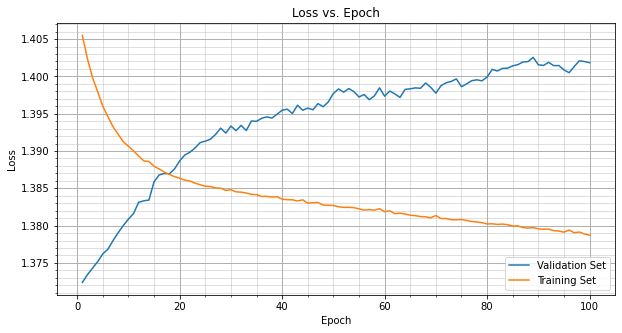

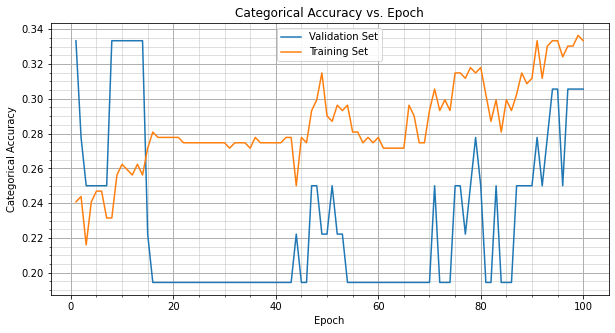

In [7]:
epochvals = np.arange(1,numepochs + 1)
plt.figure(0)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals, seasmodmetrics.history['val_loss'])
plt.plot(epochvals, seasmodmetrics.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Set','Training Set'])
plt.title('Loss vs. Epoch')
plt.savefig('seas-neuralnet_loss')

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals,seasmodmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,seasmodmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
plt.savefig('seas-neuralnet_acc')

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape=(3,),activation="relu"))
model.add(tf.keras.layers.Dense(32,activation="relu"))
model.add(tf.keras.layers.Dense(4,activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1/10000), \
              loss=keras.losses.CategoricalCrossentropy(), \
              metrics=[keras.metrics.CategoricalAccuracy()],)

gamedf_T_mod = gamedf_T.dropna(axis=0)
slotscoinsin = gamedf_T_mod.loc[:,'Slots Total Coins In'].to_numpy()[:,1:].flatten(order='F')
slotsagp = gamedf_T_mod.loc[:,'Slots Total AGP'].to_numpy()[:,1:].flatten(order='F')
slotshold = gamedf_T_mod.loc[:,'Slots Total Hold %'].to_numpy()[:,1:].flatten(order='F')

xdata = np.c_[slotscoinsin, slotsagp, slotshold]

xdata = xdata / xdata.max(axis=0) # Normalized the data
rowlen = int(len(xdata) / 4)


arr1 = np.full(shape=rowlen, fill_value=0, dtype=np.int64)
arr2 = np.full(shape=rowlen, fill_value=1, dtype=np.int64)
arr3 = np.full(shape=rowlen, fill_value=2, dtype=np.int64)
arr4 = np.full(shape=rowlen, fill_value=3, dtype=np.int64)

ydata = np.concatenate((arr1,arr2,arr3,arr4), axis=None)
ydata = to_categorical(ydata, num_classes = 4)
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=1/10, random_state=101, shuffle=True)

y_train = np.asarray(y_train, dtype= np.int64)
y_test = np.asarray(y_test, dtype= np.int64)
x_train = np.asarray(x_train, dtype= np.float64)
x_test = np.asarray(x_test, dtype= np.float64)

numepochs = 100
modmetrics = model.fit(x = x_train, y = y_train, validation_data=(x_test, y_test), batch_size = 10, epochs = numepochs, shuffle = True, verbose = 2)

Epoch 1/100
33/33 - 1s - loss: 1.4351 - categorical_accuracy: 0.2284 - val_loss: 1.4924 - val_categorical_accuracy: 0.3333
Epoch 2/100
33/33 - 0s - loss: 1.4224 - categorical_accuracy: 0.2716 - val_loss: 1.4729 - val_categorical_accuracy: 0.2500
Epoch 3/100
33/33 - 0s - loss: 1.4129 - categorical_accuracy: 0.2685 - val_loss: 1.4584 - val_categorical_accuracy: 0.2222
Epoch 4/100
33/33 - 0s - loss: 1.4039 - categorical_accuracy: 0.3951 - val_loss: 1.4451 - val_categorical_accuracy: 0.4167
Epoch 5/100
33/33 - 0s - loss: 1.3961 - categorical_accuracy: 0.5093 - val_loss: 1.4328 - val_categorical_accuracy: 0.4167
Epoch 6/100
33/33 - 0s - loss: 1.3893 - categorical_accuracy: 0.5093 - val_loss: 1.4246 - val_categorical_accuracy: 0.4167
Epoch 7/100
33/33 - 0s - loss: 1.3825 - categorical_accuracy: 0.5093 - val_loss: 1.4144 - val_categorical_accuracy: 0.4167
Epoch 8/100
33/33 - 0s - loss: 1.3762 - categorical_accuracy: 0.5093 - val_loss: 1.4045 - val_categorical_accuracy: 0.4167
Epoch 9/100
33/3

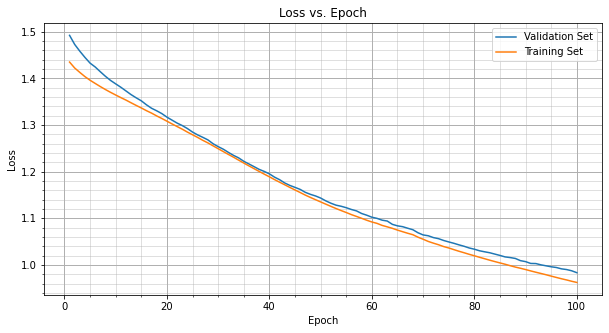

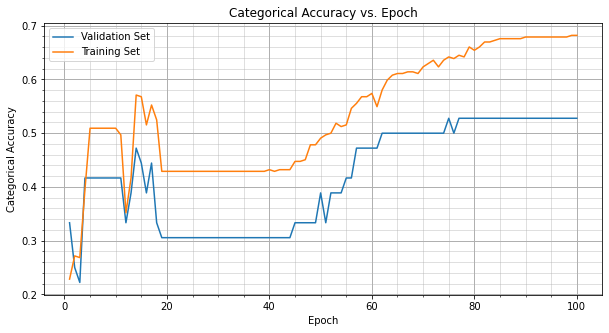

In [9]:
epochvals = np.arange(1,numepochs + 1)
plt.figure(0)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals, modmetrics.history['val_loss'])
plt.plot(epochvals, modmetrics.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Set','Training Set'])
plt.title('Loss vs. Epoch')
plt.savefig('neuralnet_loss')

plt.figure(1)
plt.minorticks_on()
plt.grid(which='minor', alpha=0.5)
plt.grid(which='major', linewidth=1)
plt.plot(epochvals,modmetrics.history['val_categorical_accuracy'])
plt.plot(epochvals,modmetrics.history['categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend(['Validation Set','Training Set'])
plt.title('Categorical Accuracy vs. Epoch')
plt.savefig('neuralnet_acc')

54241690.602
61103879.675
[66175508.21800001, 58391299.796000004, 62437215.66400001, 61850094.47800001, 72564915.35500002, 69913377.28500001, 67275419.086, 64592279.285000004, 61529880.907000005, 54241690.602, 61694620.507999994, 61103879.675]


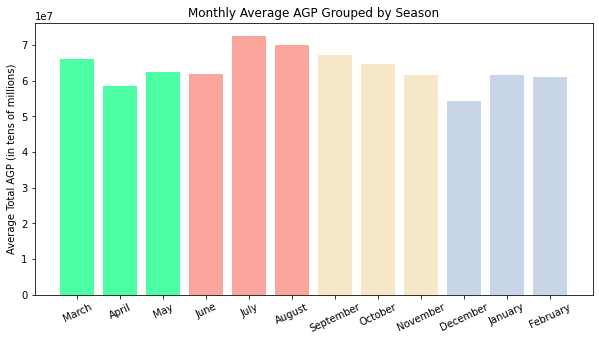

In [10]:

seaave=state_totals.dropna(axis=0)


nov=seaave[seaave['month'].str.contains('NOV')]
#seaave=seaave[:,'Slots Total AGP'].to_numpy().flatten(order='F')
dec=seaave[seaave['month'].str.contains('DEC')]
jan=seaave[seaave['month'].str.contains('JANUARY')]
feb=seaave[seaave['month'].str.contains('FEB')]
mar=seaave[seaave['month'].str.contains('MARCH')]
apr=seaave[seaave['month'].str.contains('APRI')]
may=seaave[seaave['month'].str.contains('MAY')]
jun=seaave[seaave['month'].str.contains('JUNE')]
jul=seaave[seaave['month'].str.contains('JULY')]
aug=seaave[seaave['month'].str.contains('AUGUST')]
sep=seaave[seaave['month'].str.contains('SEPT')]
octo=seaave[seaave['month'].str.contains('OCTO')]
decave=dec['Slots Total AGP'].mean()

janave=jan['Total Devices Total AGP'].mean()
febave=feb['Total Devices Total AGP'].mean()
marave=mar['Total Devices Total AGP'].mean()
aprave=apr['Total Devices Total AGP'].mean()
mayave=may['Total Devices Total AGP'].mean()
junave=jun['Total Devices Total AGP'].mean()
julave=jul['Total Devices Total AGP'].mean()
augave=aug['Total Devices Total AGP'].mean()
sepave=sep['Total Devices Total AGP'].mean()
octoave=octo['Total Devices Total AGP'].mean()
novave=nov['Total Devices Total AGP'].mean()
print(decave)
print(febave)

df2=[marave,aprave,mayave,junave,julave,augave,sepave,octoave,novave,decave,janave,febave]
print(df2)
objects = ('February', "January", "December" ,"November", "October","September",'August', 'July', 'June', 'May', 'April', 'March' )
objects = ('March', "April", "May" ,"June", "July","August",'September', 'October', 'November', 'December', 'January', 'February' )
y_pos = np.arange(len(objects))
performance = df2

plt.bar(y_pos, performance, align='center', alpha=0.7, color=['springgreen', 'springgreen', 'springgreen','salmon','salmon','salmon','wheat', 'wheat','wheat','lightsteelblue', 'lightsteelblue', 'lightsteelblue'])
plt.xticks(y_pos, objects, rotation=25)
plt.ylabel('Average Total AGP (in tens of millions)')
plt.title('Monthly Average AGP Grouped by Season')
plt.savefig('barchart.png')
plt.show()



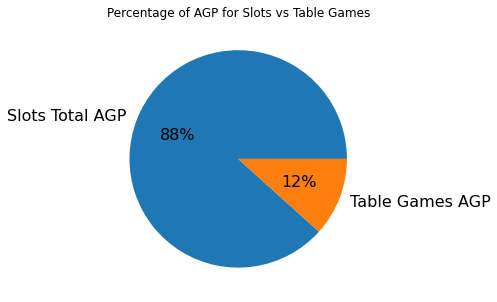

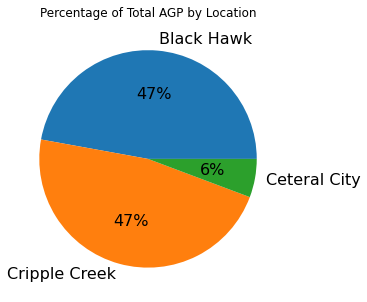

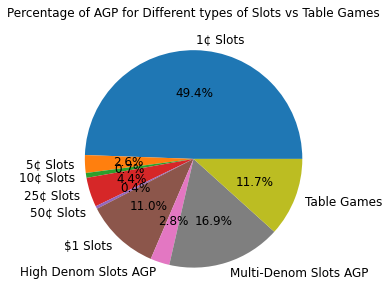

In [11]:
import random

slotave=state_totals["Slots Total AGP"].mean()
tableave=state_totals["Table Games AGP"].mean()
df3=[slotave,tableave]
mylabels = ["Slots Total AGP", "Table Games AGP"]

plt.pie(df3, labels = mylabels,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.title("Percentage of AGP for Slots vs Table Games")
plt.savefig('piechart2.png')
plt.show() 
plt.savefig('barchart.png')
blackhawkave=black_totals['Total Devices Total AGP'].mean()
crippleave=black_totals['Total Devices Total AGP'].mean()
centeralave=central_totals['Total Devices Total AGP'].mean()
mylabels2 = ["Black Hawk", "Cripple Creek", "Ceteral City"]
df4=[blackhawkave,crippleave,centeralave]
plt.pie(df4,labels=mylabels2,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.title("Percentage of Total AGP by Location")
plt.savefig('piechart1.png')
plt.show()

mylables3=['1¢ Slots','5¢ Slots','10¢ Slots','25¢ Slots','50¢ Slots','$1 Slots','High Denom Slots AGP','Multi-Denom Slots AGP','Table Games']
one=state_totals["1¢ Slots AGP"].mean()
five=state_totals["5¢ Slots AGP"].mean()
ten=state_totals["10¢ Slots AGP"].mean()
twentyfive=state_totals["25¢ Slots AGP"].mean()
fifty=state_totals["50¢ Slots AGP"].mean()
dollar=state_totals["$1 Slots AGP"].mean()
two=state_totals["$2 Slots AGP"].mean()
fived=state_totals["$5 Slots AGP"].mean()+state_totals["High Denom Slots AGP"].mean()+state_totals["$2 Slots AGP"].mean()
high=state_totals["High Denom Slots AGP"].mean()
multi=state_totals["Multi-Denom Slots AGP"].mean()
df5=[one,five,ten,twentyfive,fifty,dollar,fived,multi,tableave]
fived2=state_totals["$5 Slots AGP"].mean()

plt.pie(df5,labels=mylables3,autopct='%1.01f%%',textprops={'fontsize': 12})
plt.title("Percentage of AGP for Different types of Slots vs Table Games")
plt.savefig('piechart3.png')
plt.show()


